## 0. Packages

In [53]:
#-*- coding: utf-8 -*-

%matplotlib inline
from pyhive import hive
import os
import time
import random
import math as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve, auc 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Imputer
from sklearn.ensemble import  VotingClassifier
from sklearn2pmml import PMMLPipeline
from bayes_opt import BayesianOptimization

from sklearn.cluster import FeatureAgglomeration
from sklearn import preprocessing

from lightgbm.sklearn import LGBMClassifier


import pyWoE
import LR

plt.style.use('ggplot')
pd.set_option('display.width',500)
pd.set_option('display.max_columns',350)
pd.set_option('display.max_rows',250)

OutputPath='../../03.DataPreparation/'

In [55]:

def psi(expected_array, actual_array, buckets=10, buckettype='bins'):
    '''Calculate the PSI for a single variable 
    
    Args:
       expected_array: numpy array of original values
       actual_array: numpy array of new values, same size as expected
       buckets: number of percentile ranges to bucket the values into
       
    Returns:
       psi_value: calculated PSI value
    '''
        
    def scale_range (input, min, max):
        input += -(np.min(input))
        if max - min != 0:
            input /= np.max(input) / (max - min)
        input += min
        return input
    
    
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    
    if buckettype == 'bins':
        breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
    elif buckettype == 'quantiles':
        breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])
    
    def generate_counts(arr, breakpoints):
        '''Generates counts for each bucket by using the bucket values 
        
        Args:
           arr: ndarray of actual values
           breakpoints: list of bucket values
        
        Returns:
           counts: counts for elements in each bucket, length of breakpoints array minus one
        '''
    
        def count_in_range(arr, low, high, start):
            '''Counts elements in array between low and high values.
               Includes value if start is true
            '''
            if start:
                return(len(np.where(np.logical_and(arr>=low, arr<=high))[0]))
            return(len(np.where(np.logical_and(arr>low, arr<=high))[0]))
    
        
        counts = np.zeros(len(breakpoints)-1)
    
        for i in range(1, len(breakpoints)):
            counts[i-1] = count_in_range(arr, breakpoints[i-1], breakpoints[i], i==1)
    
        return(counts)
    
    
    expected_percents = generate_counts(expected_array, breakpoints) / len(expected_array)
    actual_percents = generate_counts(actual_array, breakpoints) / len(actual_array)
    
    def sub_psi(e_perc, a_perc):
        '''Calculate the actual PSI value from comparing the values.
           Update the actual value to a very small number if equal to zero
        '''
        if a_perc == 0:
            a_perc = 0.001
        if e_perc == 0:
            e_perc = 0.001
        
        value = (e_perc - a_perc) * np.log(e_perc / a_perc)
        return(value)
    
    psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

    return(psi_value)

def ks_table_adj(InputDf,Benchmark,ScoreVar,TargetVar,bins=20):
    '''
    功能：生成ks_table, 可观察每个bin内的正负样本数，几率，lift和ks
    Args:
       InputDf: 输入的dataframe
       ScoreVar: ks曲线横坐标变量。
       TargetVar: 目标变量，取值为1或0。示例: 's1d30'
       bins: 分箱数，默认20
       Ascending: ks曲线横坐标变量升序或降序，默认降序，不影响max_ks取值，仅影响顺序
    Returns:
       Output: ks_table, 结果见示例
    '''
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    data=InputDf[[ScoreVar,TargetVar]].copy()
    data.loc[:,'bad']=data[TargetVar]
    data.loc[:,'score']=data[ScoreVar]
    data.loc[:,'good']=1-data[TargetVar]
    
    break_points = np.stack([np.percentile(Benchmark, b) for b in np.arange(0, bins + 1) / (bins) * 100])
    #print(break_points)
    break_points = np.unique(break_points)
    labels=range(len(break_points)-1)
    data['bucket']=pd.cut(data.score,bins=break_points,labels=labels,include_lowest=True)
    grouped = data.groupby('bucket', as_index = False)
    table = pd.DataFrame(grouped.min().score, columns = ['min_score'])
    table['max_score'] = grouped.max().score
    table['min_score'] = grouped.min().score
    table['bads'] = grouped.sum().bad
    table['goods'] = grouped.sum().good
    table['total'] = table.bads + table.goods
    table['bucket_ratio'] = (table.total / table.total.sum()).apply('{0:.2%}'.format)
    table = (table.sort_values(by = 'min_score',ascending=False)).reset_index(drop = True)
    table['odds'] = (table.bads / table.goods).apply('{0:.2f}'.format)
    table['bad_rate'] = (table.bads / table.total).apply('{0:.2%}'.format)
    table['lift'] = ((table.bads / table.total) / (table.bads.sum()/table.total.sum())).apply('{0:.2f}'.format)
    table['cum_lift'] = ((table.bads.cumsum() / table.total.cumsum()) / (table.bads.sum()/table.total.sum())).apply('{0:.2f}'.format)
    table['cum_bad'] = ((table.bads / data.bad.sum()).cumsum()).apply('{0:.2%}'.format)
    table['cum_good'] = ((table.goods / data.good.sum()).cumsum()).apply('{0:.2%}'.format)
    table['ks'] = np.round(((table.bads / data.bad.sum()).cumsum() - (table.goods / data.good.sum()).cumsum()), 4) * 100
    flag = lambda x: '<<<<<<' if x == table.ks.max() else ''
    table['max_ks'] = table.ks.apply(flag)
    Output=table[['total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']]
    #print (break_points)
    return Output

def ks_table(real,pred,bins=20):
    '''
    功能：生成ks_table, 可观察每个bin内的正负样本数，几率，lift和ks
    Args:
       InputDf: 输入的dataframe
       ScoreVar: ks曲线横坐标变量。
       TargetVar: 目标变量，取值为1或0。示例: 's1d30'
       bins: 分箱数，默认20
       Ascending: ks曲线横坐标变量升序或降序，默认降序，不影响max_ks取值，仅影响顺序
    Returns:
       Output: ks_table, 结果见示例
    '''
    bad=pd.DataFrame(real,columns=['bad'])
    score=pd.DataFrame(pred,columns=['score'])
    data=pd.concat([bad,score],axis=1)
    data['good'] = 1 - data.bad
    data['bucket'] = pd.qcut(data.score,bins,duplicates='drop')
    grouped = data.groupby('bucket', as_index = False)
    table = pd.DataFrame(grouped.min().score, columns = ['min_score'])
    table['max_score'] = grouped.max().score
    table['min_score'] = grouped.min().score
    table['bads'] = grouped.sum().bad
    table['goods'] = grouped.sum().good
    table['total'] = table.bads + table.goods
    table['bucket_ratio'] = (table.total / table.total.sum()).apply('{0:.2%}'.format)
    table = (table.sort_values(by = 'min_score',ascending=False)).reset_index(drop = True)
    table['odds'] = (table.bads / table.goods).apply('{0:.2f}'.format)
    table['bad_rate'] = (table.bads / table.total).apply('{0:.2%}'.format)
    table['lift'] = ((table.bads / table.total) / (table.bads.sum()/table.total.sum())).apply('{0:.2f}'.format)
    table['cum_bad'] = ((table.bads / data.bad.sum()).cumsum()).apply('{0:.2%}'.format)
    table['ks'] = np.round(((table.bads / data.bad.sum()).cumsum() - (table.goods / data.good.sum()).cumsum()), 4) * 100
    flag = lambda x: '<<<<<<' if x == table.ks.max() else ''
    table['max_ks'] = table.ks.apply(flag)
    Output=table[['total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','odds','lift','ks','max_ks']]
    #print (table[['total','min_score','max_score','bads','bad_rate','cum_bad','lift','ks','max_ks']])
    return Output
 
def Sample_Calculate(InputDf,GroupVar,GroupValue,TargetVar):
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=pd.DataFrame()
    Output.loc[:,'Total']=InputDf.groupby(GroupVar)[TargetVar].count()
    Output.loc[:,'Bads']=InputDf.groupby(GroupVar)[TargetVar].sum()
    Output.loc[:,'Goods']=Output.Total-Output.Bads
    Output.loc[:,'BadsRate']=Output.Bads/Output.Total
    OutputFinal=Output[['Total','Goods','Bads','BadsRate']]
    return OutputFinal

def PSI_Calculate(InputDf,GroupVar,BenchmarkGroup,CompareGroup,Cols):
    expected=InputDf.loc[InputDf[GroupVar].isin(BenchmarkGroup),:][Cols].values
    Output=pd.DataFrame()
    for i in set(CompareGroup):
        actual=InputDf[InputDf[GroupVar]==i][Cols].values
        if len(expected.shape) == 1:
            psi_values = np.empty(len(expected.shape))
        else:
            psi_values = np.empty(expected.shape[1])
        for j in range(0, len(psi_values)):
            if len(psi_values) == 1:
                psi_values = psi(expected, actual, 10)
            else:
                psi_values[j] = psi(expected[:,j], actual[:,j], 10)
        ColsName=str(i)+'_PSI'
        psi_output=pd.DataFrame(psi_values,columns=[ColsName],index=Cols)
        Output=pd.concat([Output,psi_output],axis=1)
    return Output



def KS_Calculate(InputDf,GroupVar,GroupValue,Cols,TargetVar):
    '''
    功能: 利用scipy库函数计算每组中各变量的KS指标
    Args:
       InputDf: 输入的dataframe
       GroupVar: 分组依据，如按组（ins/oos/oot），月，周。示例: ['apply_month']
       GroupValue: 分组元素取值。示例: [201701, 201702]
       Cols: 特征列表。示例: ['x1', 'x2']
       TargetVar: 目标变量。示例: 's1d30'
    Returns:
       Output: 每组每个变量的ks报表，并按ks_mean降序排列显示
    '''
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=pd.DataFrame()
    for Cols_i in set(Cols):
        OutputPre=pd.DataFrame()
        for Group_i in set(GroupValue):
            ks_value=ks_2samp(InputDf.loc[(InputDf[TargetVar]==1)&(InputDf[GroupVar]==Group_i)][Cols_i], InputDf.loc[(InputDf[TargetVar]==0)&(InputDf[GroupVar]==Group_i)][Cols_i]).statistic
            ColsName=str(Group_i)+'_KS'
            ks_output=pd.DataFrame(ks_value,columns=[ColsName],index=[Cols_i])
            OutputPre=pd.concat([OutputPre,ks_output],axis=1)
        Output=pd.concat([Output,OutputPre],axis=0)
    return Output

def AUC_Calculate(InputDf,GroupVar,GroupValue,Cols,TargetVar):
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=pd.DataFrame()
    for Cols_i in set(Cols):
        OutputPre=pd.DataFrame()
        for Group_i in set(GroupValue):
            auc_value=roc_auc_score(InputDf[InputDf[GroupVar]==Group_i][TargetVar],InputDf[InputDf[GroupVar]==Group_i][Cols_i])
            ColsName=str(Group_i)+'_AUC'
            auc_output=pd.DataFrame(auc_value,columns=[ColsName],index=[Cols_i])
            OutputPre=pd.concat([OutputPre,auc_output],axis=1)
        Output=pd.concat([Output,OutputPre],axis=0)
    return Output

def KS_Table_Calculate(InputDf,GroupVar,GroupValue,TargetVar,ScoreVar,bins=20,SingleOutput=False):
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=ks_table(InputDf.loc[InputDf[GroupVar].isin(GroupValue),:][TargetVar].values,InputDf.loc[InputDf[GroupVar].isin(GroupValue),:][ScoreVar].values,bins)
    GroupValueTemp=[ str(i) for i in GroupValue ]
    Output.loc[:,GroupVar]="+".join(GroupValueTemp)
    OutputPre=pd.DataFrame()
    if SingleOutput==True:
        for Group_i in set(GroupValue):
            KS_Table=ks_table(InputDf[InputDf[GroupVar]==Group_i][TargetVar].values,InputDf[InputDf[GroupVar]==Group_i][ScoreVar].values,bins)
            KS_Table.loc[:,GroupVar]=Group_i
            OutputPre=pd.concat([OutputPre,KS_Table],axis=0)       
    Output=pd.concat([Output,OutputPre],axis=0)
    return Output
 
def KS_Table_Adj_Calculate(InputDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,bins=20,SingleOutput=False):
    InputDf=InputDf.loc[(InputDf[TargetVar].isin([0,1])),:]
    Output=ks_table_adj(InputDf.loc[InputDf[GroupVar].isin(GroupValue),:],Benchmark,ScoreVar,TargetVar,bins)
    GroupValueTemp=[ str(i) for i in GroupValue ]
    Output.loc[:,GroupVar]="+".join(GroupValueTemp)
    OutputPre=pd.DataFrame()
    if SingleOutput==True:
        for Group_i in set(GroupValue):
            KS_Table=ks_table_adj(InputDf[InputDf[GroupVar]==Group_i],Benchmark,ScoreVar,TargetVar,bins)
            KS_Table.loc[:,GroupVar]=Group_i
            OutputPre=pd.concat([OutputPre,KS_Table],axis=0)       
    Output=pd.concat([Output,OutputPre],axis=0)
    return Output

def EDD_Calculate(InputDf,GroupVar,GroupValue,Cols):
    Output=pd.DataFrame()
    for Group_i in set(GroupValue):
        OutputPre=pd.DataFrame()
        OutputPre=pd.DataFrame(InputDf[InputDf[GroupVar]==Group_i][Cols].describe().T,)
        OutputPre.loc[:,'TotalCount']=InputDf[InputDf[GroupVar]==Group_i][Cols].fillna(0).count()
        OutputPre.loc[:,GroupVar]=Group_i
        Output=pd.concat([Output,OutputPre],axis=0)
    return Output

def PredictScore(alg,algName,InputData,Predicators,KeepCols):
    ProbPre=pd.DataFrame()
    for alg, name in zip(alg, algName):
        ColumnName=name+'_Score'
        Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
        ProbPre=pd.concat([ProbPre,Prob],axis=1)
    Score=pd.concat([InputData[KeepCols],ProbPre],axis=1)
    return Score

## 1. Data

In [3]:

import findspark
findspark.init("/opt/spark")


import pandas as pd
import numpy as np
import os
from nxmodel import dstool
config = {
"spark.pyspark.driver.python":"/root/anaconda3/envs/python2.7/bin/python2.7",
"spark.pyspark.python":"/usr/local/python/bin/python2.7",
"spark.executor.memory": "16g",
"spark.dynamicAllocation.maxExecutors": "50",
"spark.dynamicAllocation.minExecutors": "10",
"spark.executorEnv.JAVA_HOME": "/usr/java/jdk1.8.0_74",
"spark.executor.cores": "1",
"spark.executorEnv.HADOOP_HOME":"/opt/cloudera/parcels/CDH/lib/hadoop",
"spark.executorEnv.HADOOP_COMMON_LIB_NATIVE_DIR":"/opt/cloudera/parcels/CDH/lib/hadoop/lib/native",
"spark.executorEnv.HADOOP_OPTS":"-Djava.library.path=/opt/cloudera/parcels/CDH/lib/hadoop/lib/native",
"spark.yarn.queue": "root.ds_prod_etl.default"
}

In [4]:
rawdata_path = '../../03.DataPreparation/%s_%s_%s_data.csv' % ('2017-12-10', '2018-04-01', 'TongdunDataV1')
if os.path.exists(rawdata_path):
    raw_data1 = pd.read_csv(rawdata_path, encoding='utf-8')
else:
    spark = dstool.connect_spark(conf=config)
    sp_df = spark.sql("select * from vdm_ds_dev.lp_multiloan_tongdun_modeling_mst where apply_date>='2017-12-10' and apply_date<'2018-04-01'")
    pd_df = sp_df.toPandas()
    pd_df.to_csv(rawdata_path, index=False, sep=',', encoding='utf-8', header=True) 
raw_data = pd.read_csv(rawdata_path, encoding='utf-8')

## 2. Data Preparation

In [5]:
date1 = '2017-12-10'
date2 = '2018-03-01'
date3 = '2018-04-01'

target_label = 'label'

def row_grouping(row):
    if (row['apply_date'] >= date1 and row['apply_date'] < date2)  and row['RandNum'] <= 0.7:
        return 'INS'  # 70%训练集
    elif (row['apply_date'] >= date1 and row['apply_date'] < date2) and row['RandNum'] > 0.3:
        return 'OOS'  # 30%验证集
    elif row['apply_date'] >= date2 and row['apply_date'] < date3:
        return 'OOT'  # OOT
    else:
        return 'NA'

In [6]:
raw_data.loc[:, 'RandNum'] = [random.random() for i in range(len(raw_data))]
raw_data.loc[:, 'Group'] = raw_data.apply(row_grouping, axis=1)

raw_data_full=raw_data.copy()
raw_data=raw_data_full.loc[raw_data_full['label'].isin([0,1]),:]
raw_data_ins = raw_data[raw_data['Group'] == 'INS']
raw_data_all = raw_data.copy()

## 3. Profiling

##### NA Check

In [7]:
DataCheck=raw_data.copy()
DataCheck.fillna(value=-9999999.0,inplace=True)
print(DataCheck.shape)

print('Type numeric:')
list_feature_Nan = []
for i in DataCheck.select_dtypes(exclude=['object']).columns:
    if (DataCheck[i] == -9999999.0).astype(int).sum() > 0:
        print("Feature: ", i, "has", round(((DataCheck[i] == -9999999.0).astype(int).sum()/DataCheck.shape[1])*100), "% of NaN")
        list_feature_Nan.append(i)

print('Type object:') 

for i in DataCheck.select_dtypes(include=['object']).columns:
    if (DataCheck[i] == -9999999.0).astype(int).sum() > 0:
        print("Feature: ", i, "has", round(((DataCheck[i] == -9999999.0).astype(int).sum()/DataCheck.shape[1])*100), "% of NaN") 

(316998, 248)
Type numeric:
Type object:


#### Target Check

In [8]:
print ('# of Samples (多头模式):')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
TargetVar='label'
print(Sample_Calculate(raw_data,GroupVar,GroupValue,TargetVar))

print ('\n# of Samples (多头模式):')
GroupVar='apply_month'
GroupValue=[201712,201801,201802,201803]
TargetVar='label'
print(Sample_Calculate(raw_data,GroupVar,GroupValue,TargetVar))

# of Samples (多头模式):
        Total   Goods  Bads  BadsRate
Group                                
INS    145828  139335  6493  0.044525
OOS     62532   59625  2907  0.046488
OOT    108638  101142  7496  0.069000

# of Samples (多头模式):
              Total   Goods  Bads  BadsRate
apply_month                                
201712        71310   68866  2444  0.034273
201801        66934   63526  3408  0.050916
201802        70116   66568  3548  0.050602
201803       108638  101142  7496  0.069000


#### EDD Check

In [9]:
all_cols = list(raw_data.columns)
except_cols = ['user_id', 'order_id', 'order_original_id', 'apply_time', 'apply_time_datetime', 'expect_capital',
               'apply_month', 'apply_week', 'loan_type', 'RandNum', 'Group','overdue_amount','overdue_amount_rate','target_s3d15',
               's1d7', 's1d15', 's1d30', 's3d15','s3d30', 'is_eff_s1d7', 'is_eff_s1d15', 'is_eff_s1d30', 'is_eff_s3d15', 'is_eff_s3d30', 
                'label' ,'target_s1d30','target_s3d30','is_reloan_zp','is_loaned','apply_date','target_label']
model_features = [x for x in set(all_cols) if x not in set(except_cols)]
print('原始特征数为: %d' % len(model_features))
model_features

原始特征数为: 228


['app_consinst_num_18m',
 'app_consbank_num_7d',
 'app_consfina_num_12m_avg',
 'app_platform_num_18m24m',
 'app_p2p_num_7d24m',
 'app_consbank_num_1m12m',
 'app_platform_num_3m_avg',
 'app_pettloan_num_7d12m',
 'app_platform_num_1m',
 'app_consfina_num_1m6m',
 'app_pettloan_num_7d18m',
 'app_platform_num_1m_ratio',
 'app_platform_num_24m',
 'app_p2p_num_7d',
 'app_consinst_num_7d1m',
 'app_platform_num_6m_ratio',
 'app_pettloan_num_6m12m',
 'app_consfina_num_7d1m',
 'app_pettloan_num_1m_ratio',
 'app_consinst_num_3m18m',
 'app_consbank_num_6m12m',
 'app_pettloan_num_12m',
 'app_p2p_num_7d18m',
 'app_consbank_num_7d1m',
 'app_platform_num_3m12m',
 'app_consbank_num_3m_ratio',
 'app_consfina_num_3m',
 'app_p2p_num_7d6m',
 'app_consbank_num_6m24m',
 'app_p2p_num_6m24m',
 'app_pettloan_num_6m',
 'app_consfina_num_24m',
 'app_pettloan_num_7d1m',
 'app_p2p_num_6m',
 'app_platform_num_1m12m',
 'app_platform_num_12m18m',
 'app_p2p_num_3m_avg',
 'app_consinst_num_3m_avg',
 'app_pettloan_num_6m1

In [10]:
delete_cols = ['app_p2p_num_6m_ratio','app_p2p_num_12m_ratio','app_p2p_num_18m_ratio']
final_cols = [x for x in set(model_features) if x not in set(delete_cols)]

In [13]:
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=model_features
EDD_df=EDD_Calculate(raw_data,GroupVar,GroupValue,Cols)
EDD_df.to_csv(OutputPath+'MultiLoan_Feature_EDD.csv')

GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=model_features
TargetVar='label'
KS_df=KS_Calculate(raw_data,GroupVar,GroupValue,Cols,TargetVar)
KS_df.to_csv(OutputPath+'MultiLoan_Feature_KS.csv')

GroupVar='Group'
BenchmarkGroup=['INS']
CompareGroup=['OOS','OOT']
Cols=model_features
PSI_df=PSI_Calculate(raw_data,GroupVar,BenchmarkGroup,CompareGroup,Cols)
PSI_df.to_csv(OutputPath+'MultiLoan_Feature_PSI.csv')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater_equal


#### IV Check

In [15]:
print('label为: %s' % target_label)
print('输出各变量的IV...')

VAR = []
IV = []
    
#print('连续性变量...')
woe = pyWoE.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
continues_cols = model_features 
for var_name in continues_cols:
    woe.fit(pd.Series(raw_data_ins[var_name]), pd.Series(raw_data_ins[target_label]))
    VAR.append(var_name)
    IV.append(woe.iv)

iv_df = pd.DataFrame({"feature": VAR})
iv_df.loc[:, 'IV'] = IV
iv_df.loc[:, 'label'] = target_label
iv_df = iv_df.sort_values(by=['IV'], ascending=False)
iv_df.loc[:, 'idx'] = range(len(iv_df))
print(iv_df.iloc[0:50,:])

iv_df.to_csv(OutputPath+'MultiLoan_Feature_IV.csv')

label为: label
输出各变量的IV...
                      feature        IV  label  idx
0        app_consinst_num_18m  0.312214  label   12
121      app_consinst_num_24m  0.304569  label   13
107   app_consinst_num_18m24m  0.283202  label   14
206        app_p2p_num_18m24m  0.276431  label   15
123       app_consinst_num_6m  0.275377  label   16
113       app_consinst_num_3m  0.250031  label   17
57    app_consinst_num_12m18m  0.247992  label   18
181        app_p2p_num_12m18m  0.237722  label   19
196   app_platform_num_1m_avg  0.229584  label   20
182        app_p2p_num_12m24m  0.205800  label   21
3     app_platform_num_18m24m  0.191783  label   22
160         app_p2p_num_1m18m  0.183058  label   23
54    app_consinst_num_12m24m  0.181966  label   24
72          app_p2p_num_1m24m  0.180373  label   25
204          app_p2p_num_3m6m  0.173356  label   26
58     app_consinst_num_6m12m  0.170837  label   27
104         app_p2p_num_1m12m  0.170564  label   28
202    app_consinst_num_6m24m  0.16175

####  Correlation

In [16]:
corr = raw_data_ins[final_cols].corr() # 计算各变量的相关性系数
corr.to_csv('../../03.DataPreparation/MultiLoan_Feature_Corr.csv')

#### Clusters

In [18]:
X_Scale=preprocessing.StandardScaler().fit_transform(raw_data_ins[final_cols])
ward = FeatureAgglomeration(n_clusters=50,linkage='ward')
ward.fit(X_Scale)
clusters=list(ward.labels_)
pd.DataFrame(clusters,columns=['cluster_index'],index=final_cols).to_csv(OutputPath+'MultiLoan_Feature_Cluster.csv')

## 4. Modeling

In [19]:
X_ins=pd.DataFrame(raw_data_ins[final_cols],dtype=np.float)
Y_ins=raw_data_ins[['label']]

In [20]:
#Missing Values Imputation
#imp=Imputer(missing_values='NaN', strategy='mean', axis=0)
#imp.fit(X_ins)

In [21]:
#X = imp.transform(X_ins)
X=X_ins.values
Y=Y_ins.values.reshape(Y_ins.values.shape[0],).astype('float64').astype(np.int64)

#### GridSearch for Random Forest

In [158]:
def RF_CV(X,y):
    param_test = {
        'max_depth': range(5,10,2),
        'n_estimators': range(50,100,25),
    }
    estimator = RandomForestClassifier(n_estimators=50, max_depth=5, max_features='log2',oob_score=True,criterion='gini',
                                 min_samples_split=400,min_samples_leaf=200,random_state=100)
    gsearch = GridSearchCV( estimator , param_grid = param_test, scoring='roc_auc', cv=3)
    gsearch.fit(X, y)
    gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    
    # 输出best score
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    # 输出最佳的分类器到底使用了怎样的参数
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

RF_CV(X,Y)

Best score: 0.742
Best parameters set:
	max_depth: 9
	n_estimators: 75


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### Bayesian Optimization for Random Forest

In [151]:
def rfccv(n_estimators, min_samples_split, max_features):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999),
            random_state=2
        ),
        X, Y, 'f1', cv=3
    ).mean()
    return val

rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (10, 250),
        'min_samples_split': (2, 25),
        'max_features': (0.1, 0.999)}
    )

gp_params = {"alpha": 1e-4}
rfcBO.maximize(n_iter=3, **gp_params)

print('-' * 53)
print('Final Results')
print('RFC: %f' % rfcBO.res['max']['max_val'])

#### Final Version on Random Forest

In [22]:
clf_rf = RandomForestClassifier(n_estimators=75, max_depth=5, max_features='log2',oob_score=True,criterion='gini',
                                 min_samples_split=400,min_samples_leaf=200,random_state=100)      
clr_rf = clf_rf.fit(X,Y)

#### Evaluation on Random Forest

In [23]:

alg=clf_rf
InputData=raw_data_all
Predicators=final_cols

KeepCols=['order_original_id', 'apply_date','apply_month', 'apply_week','Group','label','target_s1d30','target_s3d15']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators])[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)

print ('\n----------------------------------------------------------------')

print ('PSI with INS:')
GroupVar='Group'
BenchmarkGroup=['INS']
CompareGroup=['OOS','OOT']
Cols=['Score']
print(PSI_Calculate(ScoreDf,GroupVar,BenchmarkGroup,CompareGroup,Cols))

print ('\n----------------------------------------------------------------')

print ('KS on Label')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='target_s1d30'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='target_s3d15'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))



print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar='apply_month'
GroupValue=[201712,201801,201802,201803]
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar='apply_month'
GroupValue=[201712,201801,201802,201803]
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))



----------------------------------------------------------------
PSI with INS:
        OOS_PSI   OOT_PSI
Score  0.000306  0.081506

----------------------------------------------------------------
KS on Label
         INS_KS    OOS_KS    OOT_KS
Score  0.371863  0.356734  0.335221

----------------------------------------------------------------
KS on S1D30:
         INS_KS    OOS_KS    OOT_KS
Score  0.368041  0.359326  0.284784

----------------------------------------------------------------
KS on S3D15:
         INS_KS    OOS_KS    OOT_KS
Score  0.367609  0.331919  0.305379

----------------------------------------------------------------
KS on S1D30:
       201712_KS  201801_KS  201802_KS  201803_KS
Score   0.426979   0.344603   0.344288   0.335221

----------------------------------------------------------------
KS on S3D15:
       201712_KS  201801_KS  201802_KS  201803_KS
Score   0.426979   0.344603   0.344288   0.335221


#### Feature Importance from Random Forest

app_platform_num_1m          0.064164
app_platform_num_3m          0.057557
app_platform_num_6m          0.048629
app_p2p_num_3m               0.037300
app_p2p_num_12m              0.036473
app_platform_num_18m         0.032954
app_consinst_num_6m          0.032877
app_platform_num_7d          0.027902
app_p2p_num_1m               0.025975
app_p2p_num_24m              0.025182
app_consinst_num_18m24m      0.024389
app_platform_num_12m         0.022596
app_consinst_num_3m          0.021005
app_platform_num_1m_avg      0.020860
app_p2p_num_6m               0.019506
app_consinst_num_18m         0.017482
app_p2p_num_1m3m             0.016178
app_platform_num_24m         0.015824
app_p2p_num_18m              0.014456
app_p2p_num_1m24m            0.013851
app_p2p_num_1m18m            0.012016
app_p2p_num_18m24m           0.011916
app_p2p_num_1m6m             0.011474
app_consinst_num_1m          0.011079
app_consinst_num_24m         0.010598
app_consbank_num_24m         0.010509
app_p2p_num_

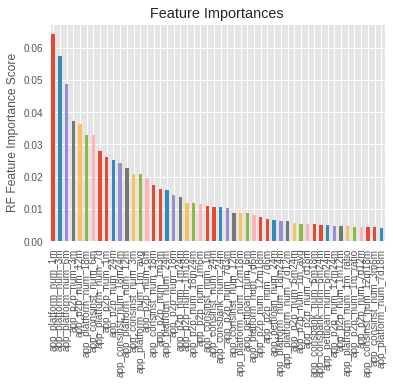

In [24]:
rf_feat_imp = pd.Series(clf_rf.feature_importances_,final_cols).sort_values(ascending=False)[0:50]
rf_feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('RF Feature Importance Score')
print(rf_feat_imp)

pd.Series(clf_rf.feature_importances_,final_cols).sort_values(ascending=False).to_csv(OutputPath+'MultiLoan_Feature_Importane_RF.csv')

#### GridSearch for XGBoost

In [186]:
def XGB_CV(X,y):
    param_test = {
        'max_depth': range(5,10,2),
        'n_estimators': range(50,100,10),
    }
    estimator = XGBClassifier(
        learning_rate =0.05,
        n_estimators=50,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.6,
        reg_alpha=2,
        colsample_bytree=0.5,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
    gsearch = GridSearchCV( estimator , param_grid = param_test, scoring='roc_auc', cv=3)
    gsearch.fit(X, y)
    gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    
    # 输出best score
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    # 输出最佳的分类器到底使用了怎样的参数
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

XGB_CV(X,Y)

KeyboardInterrupt: 

#### Bayesian Optimization for XGBoost

In [149]:
def xgbcv(n_estimators):
    val = cross_val_score(
        XGBClassifier(
        n_estimators=int(n_estimators),
        seed=27),
        X, Y, 'f1', cv=3
    ).mean()
    return val

xgbBO = BayesianOptimization(
        xgbcv,
        {'n_estimators': (10, 15)}
    )

gp_params = {"alpha": 1e-5}
xgbBO.maximize(n_iter=2, **gp_params)

print('-' * 53)
print('Final Results')
print('XGBoost: %f' % xgbBO.res['max']['max_val'])

#### Final Version on XGBoost

In [25]:
xgb = XGBClassifier(
        learning_rate =0.05,
        n_estimators=50,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.6,
        reg_alpha=2,
        colsample_bytree=0.5,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb = xgb.fit(X,Y)

#### Evaluation on XGBoost

In [27]:

alg=xgb
InputData=raw_data_all
Predicators=final_cols

KeepCols=['order_original_id', 'apply_date','apply_month', 'apply_week','Group','label','target_s1d30','target_s3d15']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)

print ('\n----------------------------------------------------------------')

print ('PSI with INS:')
GroupVar='Group'
BenchmarkGroup=['INS']
CompareGroup=['OOS','OOT']
Cols=['Score']
print(PSI_Calculate(ScoreDf,GroupVar,BenchmarkGroup,CompareGroup,Cols))

print ('\n----------------------------------------------------------------')

print ('KS on Label')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='target_s1d30'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='target_s3d15'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))



print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar='apply_month'
GroupValue=[201712,201801,201802,201803]
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar='apply_month'
GroupValue=[201712,201801,201802,201803]
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))



----------------------------------------------------------------
PSI with INS:
        OOS_PSI   OOT_PSI
Score  0.009883  0.068325

----------------------------------------------------------------
KS on Label
         INS_KS    OOS_KS    OOT_KS
Score  0.398355  0.370138  0.351462

----------------------------------------------------------------
KS on S1D30:
         INS_KS    OOS_KS    OOT_KS
Score  0.412609  0.396238  0.299457

----------------------------------------------------------------
KS on S3D15:
         INS_KS    OOS_KS    OOT_KS
Score  0.395141  0.367864  0.336556

----------------------------------------------------------------
KS on S1D30:
       201712_KS  201801_KS  201802_KS  201803_KS
Score   0.439185   0.368372   0.364338   0.351462

----------------------------------------------------------------
KS on S3D15:
       201712_KS  201801_KS  201802_KS  201803_KS
Score   0.439185   0.368372   0.364338   0.351462


#### Feature Importance from XGBoost

app_platform_num_3m           0.040172
app_platform_num_1m           0.037303
app_platform_num_6m           0.035868
app_platform_num_12m18m       0.025108
app_platform_num_3m24m        0.017217
app_p2p_num_12m               0.015782
app_platform_num_6m_ratio     0.015782
app_platform_num_3m_ratio     0.015782
app_platform_num_6m24m        0.015782
app_platform_num_3m12m        0.015065
app_platform_num_7d           0.015065
app_platform_num_6m12m        0.013630
app_p2p_num_1m                0.013630
app_platform_num_12m_ratio    0.013630
app_p2p_num_3m                0.012195
app_platform_num_3m18m        0.012195
app_p2p_num_6m12m             0.012195
app_platform_num_12m          0.012195
app_p2p_num_18m24m            0.011478
app_platform_num_18m          0.010760
app_platform_num_1m12m        0.010760
app_p2p_num_6m18m             0.010760
app_platform_num_12m24m       0.010760
app_platform_num_7d24m        0.010043
app_p2p_num_7d24m             0.010043
app_p2p_num_12m24m       

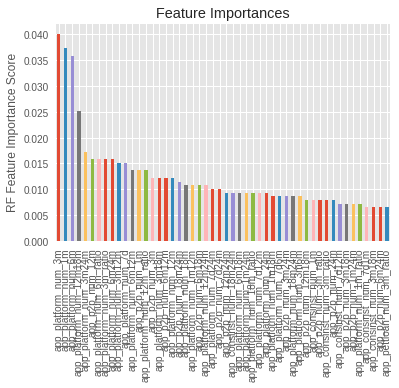

In [28]:
xgb_feat_imp = pd.Series(xgb.feature_importances_,final_cols).sort_values(ascending=False)[0:50]
xgb_feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('RF Feature Importance Score')
print(xgb_feat_imp)

pd.Series(xgb.feature_importances_,final_cols).sort_values(ascending=False).to_csv('../../03.DataPreparation/MultiLoan_Feature_Importane_XGB.csv')

### LightGBM 

#### GridSearch for LightGBM 

In [155]:
from lightgbm.sklearn import LGBMRegressor
def print_best_score(gsearch,param_test):
     # 输出best score
    print("Best score: %0.3f" % gsearch.best_score_)
    print("Best parameters set:")
    # 输出最佳的分类器到底使用了怎样的参数
    best_parameters = gsearch.best_estimator_.get_params()
    for param_name in sorted(param_test.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
            
def lightGBM_CV(X,y):
    param_test = {
        'max_depth': range(5,15,2),
        'num_leaves': range(10,40,5),
    }
    estimator = LGBMRegressor(
        num_leaves = 50, # cv调节50是最优值
        max_depth = 13,
        learning_rate =0.1, 
        n_estimators = 1000, 
        objective = 'regression', 
        min_child_weight = 1, 
        subsample = 0.8,
        colsample_bytree=0.8,
        nthread = 7
    )
    gsearch = GridSearchCV( estimator , param_grid = param_test, scoring='roc_auc', cv=5)
    gsearch.fit( X, y )
    gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    print_best_score(gsearch,param_test)

lightGBM_CV(X,Y)

#### Bayesian Optimization for LightGBM

In [ ]:
import lightgbm as lgb
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6,output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    print(train_data)
    # parameters
    def lgb_eval(n_estimators,learning_rate,num_leaves, colsample_bytree,subsample,max_depth,reg_alpha,reg_lambda,
             min_split_gain,min_child_weight):
        params = {'application':'binary','early_stopping_round':100, 'metric':'auc'}
        params["n_estimators"] = int(n_estimators)
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['reg_alpha'] = max(reg_alpha, 0)
        params['reg_lambda'] = max(reg_lambda, 0)
        params['min_split_gain'] = max(min_split_gain,0)
        params['min_child_weight'] = max(min_child_weight,0)
        #params['scale_pos_weight'] = scale_pos_weight
        print(train_data)
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {
                                        'n_estimators':(1000,5000),
                                        
                                        'learning_rate': (0.005, 0.6),
                                        'num_leaves': (12, 32),
                                        'colsample_bytree': (0.8, 1.0),
                                        'subsample':(0.8,1.0),
                                        'max_depth': (5, 9),
                                        'reg_alpha': (0, 3),
                                        'reg_lambda': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)
                                        #'scale_pos_weight':(0.2,2)
    }, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

opt_params = bayes_parameter_opt_lgb(X, Y, init_round=5, opt_round=10, n_folds=5, random_seed=6)
print(opt_params)

#### Final Version on LightGBM

In [38]:

lgb = LGBMClassifier(
        num_leaves = 20, # cv调节50是最优值
        max_depth = 5,
        learning_rate =0.1, 
        n_estimators = 100, 
        objective = 'binary', 
        min_child_weight = 1, 
        subsample = 0.8,
        colsample_bytree=0.8,
        nthread = 7
    )
lgb = lgb.fit(X,Y)

#### Evaluation on LightGBM

In [39]:

alg=lgb
InputData=raw_data_all
Predicators=final_cols

KeepCols=['order_original_id', 'apply_date','apply_month', 'apply_week','Group','label','target_s1d30','target_s3d15']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)

print ('\n----------------------------------------------------------------')

print ('PSI with INS:')
GroupVar='Group'
BenchmarkGroup=['INS']
CompareGroup=['OOS','OOT']
Cols=['Score']
print(PSI_Calculate(ScoreDf,GroupVar,BenchmarkGroup,CompareGroup,Cols))

print ('\n----------------------------------------------------------------')

print ('KS on Label')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='target_s1d30'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Cols=['Score']
TargetVar='target_s3d15'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))



print ('\n----------------------------------------------------------------')

print ('KS on S1D30:')
GroupVar='apply_month'
GroupValue=[201712,201801,201802,201803]
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))

print ('\n----------------------------------------------------------------')

print ('KS on S3D15:')
GroupVar='apply_month'
GroupValue=[201712,201801,201802,201803]
Cols=['Score']
TargetVar='label'
print(KS_Calculate(ScoreDf,GroupVar,GroupValue,Cols,TargetVar))



----------------------------------------------------------------
PSI with INS:
        OOS_PSI   OOT_PSI
Score  0.004597  0.052903

----------------------------------------------------------------
KS on Label
         INS_KS    OOS_KS    OOT_KS
Score  0.480393  0.409023  0.342624

----------------------------------------------------------------
KS on S1D30:
       INS_KS    OOS_KS    OOT_KS
Score   0.484  0.397265  0.298781

----------------------------------------------------------------
KS on S3D15:
         INS_KS    OOS_KS    OOT_KS
Score  0.477802  0.427287  0.337316

----------------------------------------------------------------
KS on S1D30:
       201712_KS  201801_KS  201802_KS  201803_KS
Score   0.495219   0.448986   0.446343   0.342624

----------------------------------------------------------------
KS on S3D15:
       201712_KS  201801_KS  201802_KS  201803_KS
Score   0.495219   0.448986   0.446343   0.342624


#### Feature Importance from LightGBM

In [ ]:
lgb_feat_imp = pd.Series(lgb.feature_importances_,final_cols).sort_values(ascending=False)[0:50]
lgb_feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('LightGBM Feature Importance Score')
print(xgb_feat_imp)

pd.Series(lgb.feature_importances_,final_cols).sort_values(ascending=False).to_csv('../../03.DataPreparation/MultiLoan_Feature_Importane_LGB.csv')

app_platform_num_3m           0.040172
app_platform_num_1m           0.037303
app_platform_num_6m           0.035868
app_platform_num_12m18m       0.025108
app_platform_num_3m24m        0.017217
app_p2p_num_12m               0.015782
app_platform_num_6m_ratio     0.015782
app_platform_num_3m_ratio     0.015782
app_platform_num_6m24m        0.015782
app_platform_num_3m12m        0.015065
app_platform_num_7d           0.015065
app_platform_num_6m12m        0.013630
app_p2p_num_1m                0.013630
app_platform_num_12m_ratio    0.013630
app_p2p_num_3m                0.012195
app_platform_num_3m18m        0.012195
app_p2p_num_6m12m             0.012195
app_platform_num_12m          0.012195
app_p2p_num_18m24m            0.011478
app_platform_num_18m          0.010760
app_platform_num_1m12m        0.010760
app_p2p_num_6m18m             0.010760
app_platform_num_12m24m       0.010760
app_platform_num_7d24m        0.010043
app_p2p_num_7d24m             0.010043
app_p2p_num_12m24m       

In [58]:
alg=clf_rf

InputData=raw_data_all
Predicators=final_cols

KeepCols=['order_original_id', 'apply_date','apply_month', 'apply_week','Group','label','target_s1d30','target_s3d15']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)


GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Benchmark=ScoreDf[ScoreDf['Group']=='INS']['Score']
ScoreVar='Score'
TargetVar='target_s1d30'
OutputCols=['Group','total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']
KS_Table=KS_Table_Adj_Calculate(ScoreDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,20,True)[OutputCols]

KS_Table.to_csv(OutputPath+'20180721_MultiLoan_KS_Table_S1D30_OutputV1.csv')

print (KS_Table)


          Group  total  min_score  max_score bucket_ratio  bads bad_rate  cum_bad cum_good  odds  lift cum_lift     ks  max_ks
0   INS+OOS+OOT  20500   0.099496   0.159826        6.47%    62    0.30%   19.87%    6.45%  0.00  3.07     3.07  13.42        
1   INS+OOS+OOT  18452   0.087582   0.099494        5.82%    44    0.24%   33.97%   12.27%  0.00  2.42     2.76  21.71        
2   INS+OOS+OOT  17798   0.078526   0.087582        5.61%    30    0.17%   43.59%   17.88%  0.00  1.71     2.43  25.71        
3   INS+OOS+OOT  17082   0.070615   0.078524        5.39%    28    0.16%   52.56%   23.26%  0.00  1.67     2.26  29.30        
4   INS+OOS+OOT  17054   0.063291   0.070612        5.38%    10    0.06%   55.77%   28.64%  0.00  0.60     1.95  27.13        
5   INS+OOS+OOT  16532   0.056498   0.063290        5.22%    24    0.15%   63.46%   33.86%  0.00  1.47     1.87  29.60        
6   INS+OOS+OOT  16166   0.050599   0.056497        5.10%    26    0.16%   71.79%   38.95%  0.00  1.63     1.84

In [59]:
alg=clf_rf

InputData=raw_data_all
Predicators=final_cols

KeepCols=['order_original_id', 'apply_date','apply_month', 'apply_week','Group','label','target_s1d30','target_s3d15']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)


GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Benchmark=ScoreDf[ScoreDf['Group']=='INS']['Score']
ScoreVar='Score'
TargetVar='target_s3d15'
OutputCols=['Group','total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']
KS_Table=KS_Table_Adj_Calculate(ScoreDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,20,True)[OutputCols]

KS_Table.to_csv(OutputPath+'20180721_MultiLoan_KS_Table_S3D15_OutputV1.csv')

print (KS_Table)


          Group  total  min_score  max_score bucket_ratio  bads bad_rate  cum_bad cum_good  odds  lift cum_lift     ks  max_ks
0   INS+OOS+OOT  20500   0.099496   0.159826        6.47%   322    1.57%   20.96%    6.40%  0.02  3.24     3.24  14.57        
1   INS+OOS+OOT  18452   0.087582   0.099494        5.82%   232    1.26%   36.07%   12.17%  0.01  2.59     2.94  23.90        
2   INS+OOS+OOT  17798   0.078526   0.087582        5.61%   130    0.73%   44.53%   17.77%  0.01  1.51     2.49  26.76        
3   INS+OOS+OOT  17082   0.070615   0.078524        5.39%   132    0.77%   53.12%   23.15%  0.01  1.59     2.28  29.98        
4   INS+OOS+OOT  17054   0.063291   0.070612        5.38%    82    0.48%   58.46%   28.53%  0.00  0.99     2.04  29.94        
5   INS+OOS+OOT  16532   0.056498   0.063290        5.22%   102    0.62%   65.10%   33.73%  0.01  1.27     1.92  31.37        
6   INS+OOS+OOT  16166   0.050599   0.056497        5.10%   104    0.64%   71.88%   38.83%  0.01  1.33     1.84

In [60]:
alg=clf_rf

InputData=raw_data_all
Predicators=final_cols

KeepCols=['order_original_id', 'apply_date','apply_month', 'apply_week','Group','label','target_s1d30','target_s3d15']

ColumnName='Score'
Prob=pd.DataFrame(alg.predict_proba(InputData[Predicators].values)[:, 1],columns=[ColumnName],index=InputData[Predicators].index)
ScoreDf=pd.concat([InputData[KeepCols],Prob],axis=1)


GroupVar='Group'
GroupValue=['INS','OOS','OOT']
Benchmark=ScoreDf[ScoreDf['Group']=='INS']['Score']
ScoreVar='Score'
TargetVar='label'
OutputCols=['Group','total','min_score','max_score','bucket_ratio','bads','bad_rate','cum_bad','cum_good','odds','lift','cum_lift','ks','max_ks']
KS_Table=KS_Table_Adj_Calculate(ScoreDf,GroupVar,GroupValue,Benchmark,ScoreVar,TargetVar,20,True)[OutputCols]

KS_Table.to_csv(OutputPath+'20180721_MultiLoan_KS_Table_S3D15_OutputV1.csv')

print (KS_Table)


          Group  total  min_score  max_score bucket_ratio  bads bad_rate  cum_bad cum_good  odds  lift cum_lift     ks  max_ks
0   INS+OOS+OOT  20500   0.099496   0.159826        6.47%  3744   18.26%   22.16%    5.58%  0.22  3.43     3.43  16.58        
1   INS+OOS+OOT  18452   0.087582   0.099494        5.82%  2288   12.40%   35.70%   10.97%  0.14  2.33     2.91  24.73        
2   INS+OOS+OOT  17798   0.078526   0.087582        5.61%  1704    9.57%   45.79%   16.33%  0.11  1.80     2.56  29.45        
3   INS+OOS+OOT  17082   0.070615   0.078524        5.39%  1484    8.69%   54.57%   21.53%  0.10  1.63     2.34  33.04        
4   INS+OOS+OOT  17054   0.063291   0.070612        5.38%  1212    7.11%   61.74%   26.81%  0.08  1.33     2.15  34.93        
5   INS+OOS+OOT  16532   0.056498   0.063290        5.22%  1022    6.18%   67.79%   31.98%  0.07  1.16     2.00  35.81        
6   INS+OOS+OOT  16166   0.050599   0.056497        5.10%   878    5.43%   72.99%   37.07%  0.06  1.02     1.87

缺失值分析及处理...
缺失率为: 0.0000
输出变量的数据分布...
初始化...


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[-inf, 6.0, 9.0, 13.0]


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


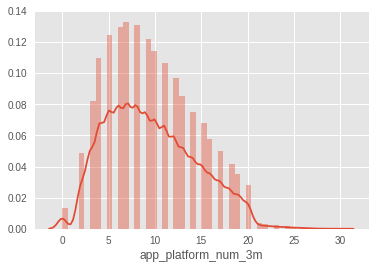

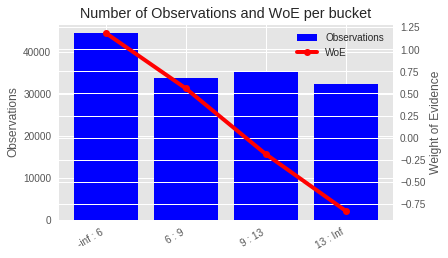

等频分箱IV： 0.549089440604683
自动分箱调整...
[-inf, 6.0, 9.0, 13.0]


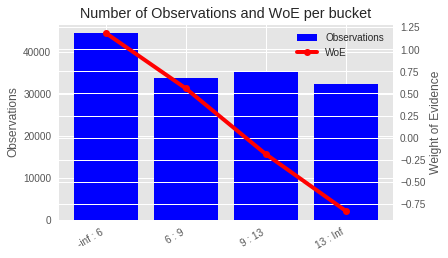

自动单调分箱IV： 0.549089440604683
       mean   bad    obs   good  good_rate       woe  odds_good       bins  \
0  0.014148   629  44460  43831   0.985852  1.185703  69.683625       -inf   
1  0.026165   883  33747  32864   0.973835  0.558546  37.218573   6.000000   
2  0.053544  1887  35242  33355   0.946456 -0.186042  17.676206   9.000000   
3  0.097151  3141  32331  29190   0.902849 -0.828977   9.293219  13.000000   

  labels  
0      0  
1      1  
2      2  
3      3  


In [30]:
Feature='app_platform_num_3m'
FeatureWoe=Feature+'_woe'

print('缺失值分析及处理...')
print('缺失率为: %.4f' % (len(raw_data_ins[raw_data_ins[Feature].isnull() == True]) / len(raw_data_ins)))

print('输出变量的数据分布...')
sns.distplot(raw_data_ins[Feature].dropna())

print('初始化...')
woe = pyWoE.WoE(qnt_num=5, min_block_size=10, v_type='c', t_type='b')
woe.fit(pd.Series(raw_data_ins[Feature]), pd.Series(raw_data_ins[target_label]))
print(list(woe.bins['bins'].values))
fig = woe.plot()
plt.show(fig)
print('等频分箱IV：',woe.iv)

print('自动分箱调整...')
woe_monotonic = woe.force_monotonic(hypothesis=1)
print(list(woe_monotonic.bins['bins'].values))
fig = woe_monotonic.plot()
plt.show(fig)
print('自动单调分箱IV：',woe_monotonic.iv)

#print('手动分箱调整...')
#woe3 = pyWoE.WoE(bins=[0.029, 0.04, 0.089, 0.11], v_type='c', t_type='b')
#woe3.fit(pd.Series(raw_data_ins['toplab_score']), pd.Series(raw_data_ins[target_label]))
#print(list(woe3.bins['bins'].values))
#fig = woe3.plot()
#plt.show(fig)
#print('手动分箱IV：',woe3.iv)

woe_final = woe_monotonic

bins_map = woe_final.bins.copy()
bins_map.loc[:, 'feature'] = FeatureWoe

print (woe_final.bins)